# Feed-forward Neural Network

#### Choosing best parameters for grid search

C:\Users\prajj\AppData\Local\Temp/ipykernel_9056/1728908429.py:41: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.009568370126057789 using {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Epoch 1/100
12/12 [==============================] - 1s 27ms/step - loss: 0.1507 - val_loss: 0.0917
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.1026 - val_loss: 0.0672
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0780 - val_loss: 0.0511
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0601 - val_loss: 0.0434
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0498 - val_loss: 0.0375
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0433 - val_loss: 0.0356
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0387 - val_loss: 0.0364
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0353 - val_loss: 0.0336
Epoch 9/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0331 - val_loss: 0.0345
Epoch 10/100
12/

12/12 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0136
Epoch 83/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0142
Epoch 84/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0137
Epoch 85/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0134
Epoch 86/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0147
Epoch 87/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0131
Epoch 88/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0137
Epoch 89/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0097 - val_loss: 0.0140
Epoch 90/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0149
Epoch 91/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0136
Epoch 92/100


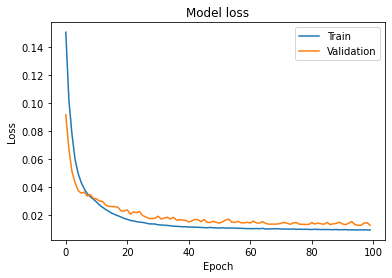

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
data = pd.read_csv("Data.csv")

# Normalize the Data
X = data.drop('HV', axis=1)
y = data['HV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the model-building function
def create_model(optimizer='adam'):
    model = Sequential([
        Dense(5, input_dim=3, activation='relu'),
        Dense(3, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'batch_size': [10, 20, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Define the KFold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with KFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform the grid search
grid_result = grid.fit(X_train, y_train)

# Summarize the results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Rebuild the model using the best parameters
best_model = create_model(optimizer=grid_result.best_params_['optimizer'])
history = best_model.fit(X_train, y_train, 
                         epochs=grid_result.best_params_['epochs'], 
                         batch_size=grid_result.best_params_['batch_size'], 
                         validation_split=0.2, verbose=1)


# Evaluate the model on the test set
loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {loss}')



y_pred = best_model.predict(X_test)

# Convert MSE to RMSE for interpretability
rmse = np.sqrt(loss)
print(f'Test RMSE: {rmse}')
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

# R-squared score for the training set
y_train_pred = best_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared score for training set: {r2_train}')

# R-squared score for the test set
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print(f'R-squared score for test set: {r2_test}')


# Display the equation (approximation using weights and biases)
weights = best_model.get_weights()
print("Model weights (approximation):")
print(weights)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



#### Kfold cross-validation 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Load your dataset
data = pd.read_csv("Data.csv")

# Preprocess the data
X = data.drop('HV', axis=1)
y = data['HV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a function to create the model
def create_model():
    model = Sequential([
        Dense(5, input_dim=X_train.shape[1], activation='relu'),
        Dense(3, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.01), loss='mean_squared_error')
    return model

# Wrap the Keras model with KerasRegressor for use with scikit-learn
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
cv_scores = cross_val_score(model, X_scaled, y, cv=kfold, scoring='neg_mean_squared_error')
cv_results = cross_val_score(model, X_scaled, y, cv=kfold, scoring='r2')
mean_r2 = np.mean(cv_results)
std_r2 = np.std(cv_results)
# Convert negative MSE to positive
cv_mse_scores = -cv_scores
cv_rmse_scores = np.sqrt(cv_mse_scores)

print(f"Cross-Validation MSE Scores: {cv_mse_scores}")
print(f"Cross-Validation RMSE Scores: {cv_rmse_scores}")
print(f"Cross-Validation R^2 Scores: {cv_results}")
print(f"Mean MSE across folds: {cv_scores.mean()}")
print(f"Mean RMSE across folds: {cv_rmse_scores.mean()}")
print(f"RMSE Variance across folds: {cv_rmse_scores.var()}")
print(f"R^2  across folds: {cv_results.mean()}")
print(f'Cross-Validated R²: {mean_r2:.2f} ± {std_r2:.2f}')
# Train the model on the full training data
model.fit(X_train, y_train)

# Evaluate on the test set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate performance metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)

# Print performance metrics
print("\nTraining Performance:")
print(f"MAE: {train_mae}")
print(f"MSE: {train_mse}")
print(f"RMSE: {train_rmse}")
print(f"R^2: {train_r2}")

print("\nTest Performance:")
print(f"MAE: {test_mae}")
print(f"MSE: {test_mse}")
print(f"RMSE: {test_rmse}")
print(f"R^2: {test_r2}")

# Check train-test performance gap (indicative of variance)
performance_gap = train_rmse - test_rmse
print(f"\nTrain-Test RMSE Performance Gap: {performance_gap}")


C:\Users\prajj\AppData\Local\Temp/ipykernel_9056/2201893679.py:35: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


Cross-Validation MSE Scores: [0.00584229 0.00760011 0.00483437 0.00647    0.00576924]
Cross-Validation RMSE Scores: [0.0764349  0.0871786  0.06952966 0.08043633 0.07595548]
Cross-Validation R^2 Scores: [0.71283779 0.79921683 0.62871062 0.41796355 0.74231476]
Mean MSE across folds: -0.0061032029483067095
Mean RMSE across folds: 0.07790699495865594
RMSE Variance across folds: 3.370308481866863e-05
R^2  across folds: 0.6602087098652522
Cross-Validated R²: 0.66 ± 0.13

Training Performance:
MAE: 0.06798425312553133
MSE: 0.009348541916754206
RMSE: 0.09668785816613276
R^2: 0.538738743408563

Test Performance:
MAE: 0.06681659153529576
MSE: 0.009092928850181682
RMSE: 0.09535685004330671
R^2: 0.5101654423275038

Train-Test RMSE Performance Gap: 0.0013310081228260495


In [3]:
import numpy as np

# Assuming 'y_test' are the actual values and 'y_pred' are the predicted values
y_test = np.array([y_test])  # Replace with actual test set
y_pred = np.array([y_test_pred])  # Replace with your model's predictions

# Margin of Deviation
margin_of_deviation = np.abs(y_test - y_pred)

# Relative Error (in percentage)
relative_error = (margin_of_deviation / y_test) * 100

# Print results
print("Margin of Deviation:", margin_of_deviation)
print("Relative Error (%):", relative_error)

#average
print("Average value of Margin of Deviation:", np.mean(margin_of_deviation))
print("Average value of Relative Error (%):", np.mean(relative_error))

Margin of Deviation: [[0.09542867 0.10457133 0.038438   0.29542867 0.10457133 0.10457133
  0.05633439 0.01155859 0.29542867 0.05567274 0.09542867 0.00247473
  0.09960819 0.02102277 0.01480488 0.00457133 0.09542867 0.00932614
  0.01448053 0.09542867 0.10457133 0.03182286 0.09636656 0.05031756
  0.00688112 0.10457133 0.00457133 0.03329751 0.06177124 0.00457133
  0.07883695 0.00844672 0.00457133 0.04730353 0.0861017 ]]
Relative Error (%): [[23.85716736 52.28566527  6.40633305 49.23811158 52.28566527 52.28566527
  18.77812942  2.88964659 49.23811158  9.27879016 23.85716736  0.49494505
  33.20273161  5.2556932   2.46747931  1.52377685 23.85716736  2.33153403
   2.89610624 23.85716736 52.28566527  6.36457205 16.06109341  8.38626027
   1.37622356 52.28566527  1.52377685  8.32437873 15.44280946  1.52377685
  13.13949227  2.11167932  1.52377685  7.88392226 21.52542621]]
Average value of Margin of Deviation: 0.06681659153529576
Average value of Relative Error (%): 18.45844493025825


In [17]:
y_pred

array([[0.30457133, 0.30457133, 0.561562  , 0.30457133, 0.30457133,
        0.30457133, 0.3563344 , 0.3884414 , 0.30457133, 0.54432726,
        0.30457133, 0.49752527, 0.3996082 , 0.42102277, 0.5851951 ,
        0.30457133, 0.30457133, 0.40932614, 0.51448053, 0.30457133,
        0.30457133, 0.46817714, 0.50363344, 0.54968244, 0.5068811 ,
        0.30457133, 0.30457133, 0.43329751, 0.33822876, 0.30457133,
        0.52116305, 0.39155328, 0.30457133, 0.55269647, 0.3138983 ]],
      dtype=float32)

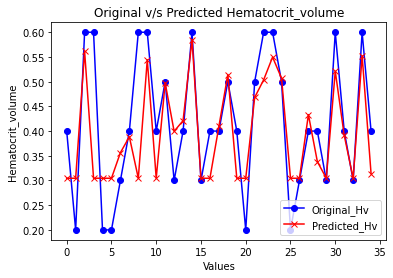

In [20]:
Original_HV = [0.4, 0.2, 0.6, 0.6, 0.2, 0.2, 0.3, 0.4, 0.6, 0.6, 0.4, 0.5, 0.3,
        0.4, 0.6, 0.3, 0.4, 0.4, 0.5, 0.4, 0.2, 0.5, 0.6, 0.6, 0.5, 0.2,
        0.3, 0.4, 0.4, 0.3, 0.6, 0.4, 0.3, 0.6, 0.4]
Predicted_HV = [0.30457133, 0.30457133, 0.561562  , 0.30457133, 0.30457133,
        0.30457133, 0.3563344 , 0.3884414 , 0.30457133, 0.54432726,
        0.30457133, 0.49752527, 0.3996082 , 0.42102277, 0.5851951 ,
        0.30457133, 0.30457133, 0.40932614, 0.51448053, 0.30457133,
        0.30457133, 0.46817714, 0.50363344, 0.54968244, 0.5068811 ,
        0.30457133, 0.30457133, 0.43329751, 0.33822876, 0.30457133,
        0.52116305, 0.39155328, 0.30457133, 0.55269647, 0.3138983 ]
plt.plot(Original_HV, color="blue", label="Original_Hv", marker='o')
plt.plot(Predicted_HV, color="red", label="Predicted_Hv", marker='x')
plt.title("Original v/s Predicted Hematocrit_volume")
plt.xlabel("Values")
plt.ylabel("Hematocrit_volume")
plt.legend()
plt.show()

## Back-propagation ANN Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Forward pass
def forward_pass(X, weights, biases):
    layer_input = np.dot(X, weights[0]) + biases[0]
    layer_output = relu(layer_input)  # Use ReLU instead of sigmoid
    final_input = np.dot(layer_output, weights[1]) + biases[1]
    final_output = final_input  # Linear output for regression
    return layer_output, final_output

# Backward pass
def backward_pass(X, y_true, y_pred, layer_output, weights, biases, learning_rate=0.001):  # Lower learning rate
    error = y_true - y_pred
    d_output = error  # Derivative of loss w.r.t final output (linear activation)
    
    # Update weights and biases for output layer
    weights[1] += learning_rate * np.dot(layer_output.T, d_output)
    biases[1] += learning_rate * np.sum(d_output, axis=0)
    
    # Propagate the error back to the hidden layer
    d_hidden_layer = np.dot(d_output, weights[1].T) * relu_derivative(layer_output)
    
    # Update weights and biases for hidden layer
    weights[0] += learning_rate * np.dot(X.T, d_hidden_layer)
    biases[0] += learning_rate * np.sum(d_hidden_layer, axis=0)

# Initialize weights and biases
np.random.seed(42)
weights = [
    np.random.rand(3, 5) * 0.1,  # Scale down initial weights
    np.random.rand(5, 1) * 0.1
]
biases = [
    np.random.rand(5) * 0.1,  # Scale down initial biases
    np.random.rand(1) * 0.1
]

# Load the dataset
data = pd.read_csv("Data.csv")

# Normalize the Data
X = data.drop('HV', axis=1)
y = data['HV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape y_train and y_test to be 2D arrays
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Training loop
epochs = 10000
learning_rate = 0.001  # Lower learning rate
for epoch in range(epochs):
    # Forward pass
    layer_output, y_pred = forward_pass(X_train, weights, biases)
    
    # Compute loss
    loss = mse_loss(y_train, y_pred)
    
    # Backward pass (Backpropagation)
    backward_pass(X_train, y_train, y_pred, layer_output, weights, biases, learning_rate)
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Final output after training
_, final_output_train = forward_pass(X_train, weights, biases)
_, final_output_test = forward_pass(X_test, weights, biases)

# Flatten the final outputs and targets for easy comparison
final_output_train = final_output_train.flatten()
final_output_test = final_output_test.flatten()
y_train = y_train.flatten()
y_test = y_test.flatten()

print(f'Final predicted output for training set: {final_output_train}')
print(f'Final predicted output for test set: {final_output_test}')

# Compute and print final loss on test set
final_loss_test = mse_loss(y_test, final_output_test)
print(f'Final loss on test set: {final_loss_test}')


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, final_output_train)
mse_test = mean_squared_error(y_test, final_output_test)

# Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train, final_output_train)
mae_test = mean_absolute_error(y_test, final_output_test)

# R-squared (R²) Score
r2_train = r2_score(y_train, final_output_train)
r2_test = r2_score(y_test, final_output_test)

print("Evaluation Metrics for Training Set:")
print(f"  MSE: {mse_train}")
print(f"  MAE: {mae_train}")
print(f"  R²: {r2_train}")

print("\nEvaluation Metrics for Test Set:")
print(f"  MSE: {mse_test}")
print(f"  MAE: {mae_test}")
print(f"  R²: {r2_test}")


In [ ]:
print(y_test)
print(final_output_test)

## Confidence Interval for Feed-forward

Test Sample 1:
Predicted Value: 0.3668092447519302
95% Confidence Interval: [0.21949808299541473, 0.5153718307614322]

Test Sample 2:
Predicted Value: 0.20870716884732246
95% Confidence Interval: [0.10472561717033387, 0.3026757493615148]

Test Sample 3:
Predicted Value: 0.5729514881968498
95% Confidence Interval: [0.4570127449929714, 0.6680410772562027]

Test Sample 4:
Predicted Value: 0.5016644144058228
95% Confidence Interval: [0.3498501695692539, 0.6722400903701782]

Test Sample 5:
Predicted Value: 0.33448287755250933
95% Confidence Interval: [0.20606609992682934, 0.4487515866756439]



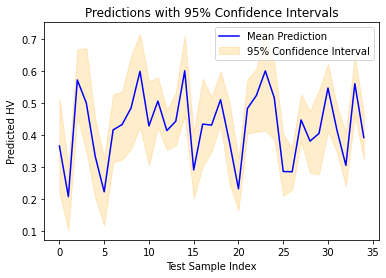

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the dataset
data = pd.read_csv("Data.csv")

# Normalize the Data
X = data.drop('HV', axis=1)
y = data['HV']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a function to create the model
def create_model():
    model = Sequential([
        Dense(5, input_dim=X_train.shape[1], activation='relu'),
        Dense(3, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=RMSprop(learning_rate=0.01), loss='mean_squared_error')
    return model

# Bootstrapping
n_bootstraps = 100  # Number of bootstrap samples
predictions = np.zeros((n_bootstraps, X_test.shape[0]))

for i in range(n_bootstraps):
    # Resample with replacement from the training set
    indices = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0], replace=True)
    X_resample = X_train[indices]
    y_resample = y_train.iloc[indices]

    # Create and train the model
    model = create_model()
    model.fit(X_resample, y_resample, epochs=100, batch_size=32, verbose=0)

    # Make predictions on the test set
    predictions[i] = model.predict(X_test).flatten()

# Calculate the mean prediction and the 95% confidence intervals
mean_prediction = np.mean(predictions, axis=0)
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)

# Print the results
for i in range(5):
    print(f"Test Sample {i+1}:")
    print(f"Predicted Value: {mean_prediction[i]}")
    print(f"95% Confidence Interval: [{lower_bound[i]}, {upper_bound[i]}]\n")

# Optionally, you can plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(len(mean_prediction)), mean_prediction, 'b', label='Mean Prediction')
plt.fill_between(range(len(mean_prediction)), lower_bound, upper_bound, color='orange', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Test Sample Index')
plt.ylabel('Predicted HV')
plt.title('Predictions with 95% Confidence Intervals')
plt.legend()
plt.show()
